# Bloco 3

<p align="justify">
Este trabalho é referente as tarefas desenvolvidas no Bloco 2. Espera-se desenvolver um projeto capaz de utilizar os comandos aprendidos pela linguagem de programação Python, na disciplina de Aprendizado de Máquina, além de desenvolver um sistema de previsão através de Machine Learning. Neste bloco, as discentes estão aplicando modelos de treinamento de Machine Learning e analisando o metódo que melhor se adequa a target e os features estabelecidos. O grupo desenvolvedor é composto pelas discentes:
<p align="justify">
Isabela Bento Beneti </p>
<p align="justify">
Monyque Karoline de Paula Silva </p>
<p align="justify">
Sofia Baccega C.C. de Oliveira </p>
<p align="justify">
Sophia Figueiredo Michel </p>
<hr>

### **COLETA DE DADOS**

In [52]:
# Importando bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import tree, utils, preprocessing
from itertools import product
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [53]:
# Dados do Cerrado Brasileiro, armazenados mensalmente via .csv
arquivos = ['janeiro.csv','fev.csv','marco.csv','abril.csv','maio.csv','junho.csv','julho.csv']

In [54]:
def read_csv(list_of_files):
    dfs = []
    for x in list_of_files:
        file = pd.read_csv(x, sep=',')
        dfs.append(file)
    df = pd.concat(dfs).reset_index(drop=True)
        
    return df

In [55]:
meses = read_csv(arquivos)

In [56]:
# Dados trabalhados para a eliminação de NaN nas colunas e identificação dos tipos de dados
meses.convert_dtypes()
meses.dropna(how='any', inplace=True)

In [57]:
meses.drop(columns=['Unnamed: 0','estado', 'municipio', 'pais', 'municipio_id', 'estado_id', 'pais_id', 'bioma'], axis = 1, inplace=True)

In [58]:
meses['satelite']= meses['data_hora_gmt']
meses['satelite'] = meses['satelite'].str[11:13] #criando coluna "hora" a partir de "data_hora_gmt"
meses['data_hora_gmt'] = meses['data_hora_gmt'].str[6] #criando coluna "mes" a partir de "data_hora_gmt"
meses_fogo = meses['risco_fogo'] > 0
meses.rename(columns={'satelite': 'hora'}, inplace= True)
meses.rename(columns={'data_hora_gmt': 'mes'}, inplace = True)
meses = meses[meses_fogo]

In [59]:
meses = meses.reset_index()
del meses['index']
display(meses)

,lat,lon,mes,hora,numero_dias_sem_chuva,precipitacao,risco_fogo
0,-12.314859,-43.234066,3,01,9.0,2.7,1.0
1,-20.227880,-46.415940,3,01,8.0,0.0,0.3
2,-20.229250,-46.426820,3,01,8.0,0.0,0.3
3,-20.238930,-46.425510,3,01,8.0,0.0,0.4
4,-20.237550,-46.414600,3,01,8.0,0.0,0.4
...,...,...,...,...,...,...,...
265136,-6.360000,-45.670000,7,23,46.0,0.0,1.0
265137,-6.360000,-45.690000,7,23,46.0,0.0,1.0
265138,-6.400000,-44.140000,7,23,34.0,0.0,1.0
265139,-6.350000,-45.670000,7,23,46.0,0.0,1.0


In [69]:
meses["mes"] = meses["mes"].astype(float)
meses["hora"] = meses["hora"].astype(float)
print(meses.dtypes)

lat                      float64
lon                      float64
mes                      float64
hora                     float64
numero_dias_sem_chuva    float64
precipitacao             float64
risco_fogo               float64
dtype: object


<hr>

### PCA

In [70]:
# Estabelecendo as features
FEATURES = ["numero_dias_sem_chuva", "precipitacao", "risco_fogo", "lat", "lon","hora","mes"]
# Normalizando os dados
X = meses.reindex(FEATURES, axis=1)
sc = StandardScaler()
sc.fit(X)
X_norm = sc.transform(X)
pca = PCA()
pca.fit(X_norm)
X_pca = pca.transform(X_norm)

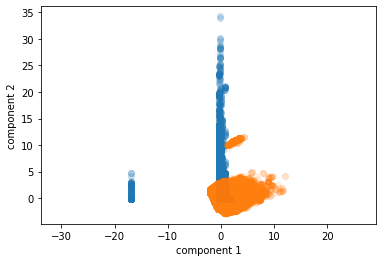

In [71]:
# Graficando o PCA
plt.scatter(X_norm[:, 0], X_norm[:, 1], alpha=0.2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.1)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.axis('equal');

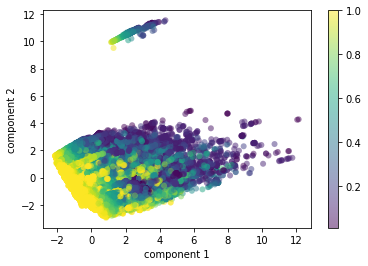

In [72]:
# Colorindo os pontos de acordo com o risco de fogo, para entender se a PCA agrupou os dados de alguma maneira
plt.scatter(X_pca[:, 0], X_pca[:, 1], edgecolor='none', alpha=0.5, c=meses["risco_fogo"].values)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

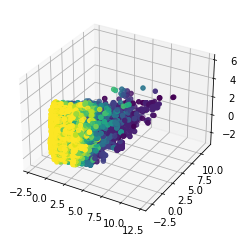

In [73]:
# Plotando gráfico 3D
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=meses["risco_fogo"].values)

In [74]:
# Matriz de loadings, para investigar o que cada componente principal levou em conta em relação as features originais
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
X_pca.head()

loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
numero_dias_sem_chuva,-0.188968,-0.486537,0.124816,0.402772,-0.721887,0.161055,0.052049
precipitacao,0.296427,0.095765,0.154775,0.862696,0.348101,-0.045328,-0.107385
risco_fogo,-0.537484,-0.349566,0.055220,0.014665,0.257822,-0.421686,-0.584260
lat,-0.385857,0.555037,-0.030917,0.102440,-0.126876,0.565895,-0.441887
lon,-0.311979,0.547545,0.259420,0.120559,-0.287177,-0.595393,0.289943
hora,-0.074910,0.064774,-0.942902,0.224180,-0.102668,-0.196180,0.042956
mes,-0.579401,-0.140880,-0.009937,0.134278,0.426759,0.284553,0.602681


array([<AxesSubplot:title={'center':'Variancia explicada'}, xlabel='Componente'>,
       <AxesSubplot:title={'center':'Variância acumulada'}, xlabel='Componente'>],
      dtype=object)

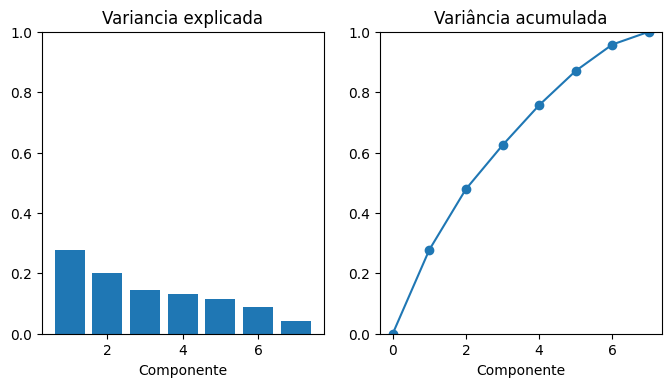

In [75]:
# graficando a variância explicada e acumulada
def plot_variance(pca, width=8, dpi=100):
    # Criar figura
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    
    # Fazer o cálculo da variância explicada
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Componente", 
        title="Variancia explicada", 
        ylim=(0.0, 1.0)
    )
    
    # Variância acumulada
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Componente", 
        title="Variância acumulada", 
        ylim=(0.0, 1.0)
    )
    
    # Detalhes da figura
    fig.set(figwidth=8, dpi=100)
    return axs

# Graficar
plot_variance(pca)

<hr>

## K-Means

In [76]:
df = meses
FEATURES = ["precipitacao","hora","mes","numero_dias_sem_chuva","lon","lat"]

X = df.reindex(FEATURES, axis=1)

In [77]:
sc = StandardScaler()
sc.fit(X)
X_norm = sc.transform(X)

In [78]:
n_clusters=3  #Define três clusters

kmeans = KMeans(            #Inicializando o K-Means
    n_clusters=n_clusters,  #Definindo número de clusters
    init='random',          #Inicialização randomica, aqui você pode tentar o K-Means++ :)
    n_init=10,              #Número de inicializações
    max_iter=300,           #Número máximo de iterações
    tol=1e-04,              #Tolerância para variação da coordenada dos centróides para definir a convergência
    random_state=0          #Define a semente aleatória
)

y_kmeans = kmeans.fit_predict(X_norm) #Fita o K-Means

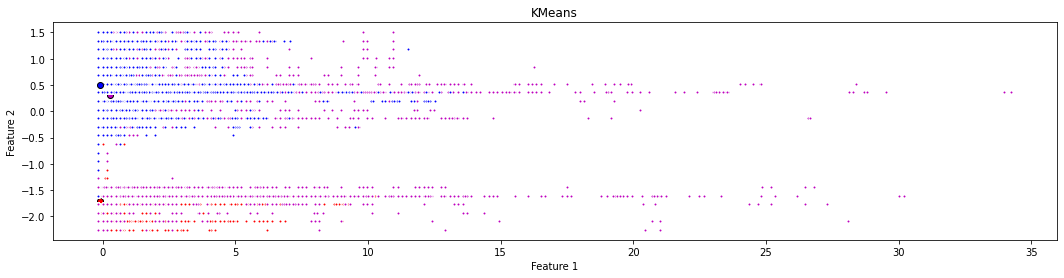

In [79]:
from sklearn.metrics.pairwise import pairwise_distances_argmin

centroids = kmeans.cluster_centers_ #Extraindo os centróides do K-Means
labels = pairwise_distances_argmin(X_norm, centroids) #Usando a função pairwise_distances_argmin 
                                                      #para dar os labels aos clusters
colors = ["r", "m", "b", "y", "k"] #Definindo a paleta de cores

fig = plt.figure(figsize=(18, 4)) #Definindo a figura e seu tamanho
ax = fig.add_subplot()             #Criando um subplot

for k, col in zip(range(n_clusters), colors): #Desempacotando a lista de número de cluster e cores.
    my_members = labels == k  #Define quais pontos são membros de cada cluster
    #print(my_members)        #Descomente essa linha para entender como se comporta a variável my_members
    cluster_center = centroids[k] #Pega as coordenadas do centróide k
    ax.plot(                      #Plota os pontos do centróide k
        X_norm[my_members, 0],    #Coordenada do eixo-x
        X_norm[my_members, 1],    #Coordenada do eixo-y
        markerfacecolor=col,      #Define a cor do ponto
        marker=".",               #Define o estilo do ponto
        markeredgecolor="w",      #Define a cor de contorno do ponto
        linewidth=0               #Largura de linha zero, para não ligar os pontos
    )
    ax.plot(                      #Plotando os centróides
        cluster_center[0],        #Coordenada x do centróide
        cluster_center[1],        #Coordenada y do centróide
        marker="o",               #Define estilo do ponto
        markerfacecolor=col,      #Define cor do ponto
        markeredgecolor="k",      #Define a cor do contorno do ponto
        markersize=6,             #Define o tamanho do ponto
        linewidth=0               #Largura de linha zero, para não ligar os pontos
    )

ax.set_title("KMeans")  #Título do gráfico
plt.xlabel('Feature 1') #Nome da componente x
plt.ylabel('Feature 2') #Nome da componente y

plt.show() #Mostrar o gráfico

In [80]:
pca = PCA()
pca.fit(X_norm)
X_pca = pca.transform(X_norm)

In [81]:
n_clusters=3

kmeans = KMeans(
    n_clusters=n_clusters, 
    init='random',
    n_init=10, 
    max_iter=300, 
    tol=1e-04, 
    random_state=0
)

y_kmeans = kmeans.fit_predict(X_pca)

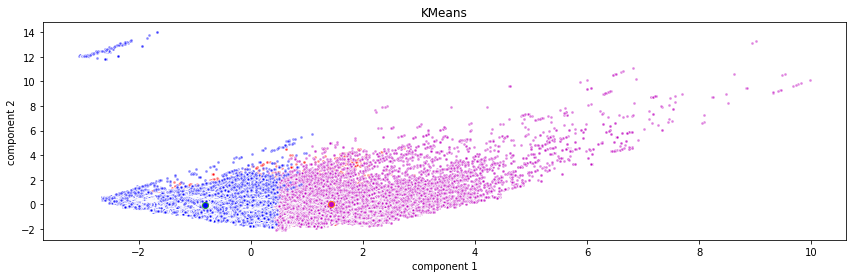

In [82]:
centroids = kmeans.cluster_centers_
labels = pairwise_distances_argmin(X_pca, centroids)
colors = ["r", "m", "b", "y", "k"]

fig = plt.figure(figsize=(14.4, 4))
ax = fig.add_subplot()

for k, col in zip(range(n_clusters), colors):
    my_members = labels == k
    cluster_center = centroids[k]
    ax.plot(
        X_pca[my_members, 0],
        X_pca[my_members, 1],
        "w", 
        markerfacecolor=col,
        marker=".",
        alpha = 0.5,
        linewidth=0)
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markersize=6,
        alpha = 1.0,
        linewidth=0
    )

ax.set_title("KMeans")
plt.xlabel('component 1')
plt.ylabel('component 2')

plt.show()

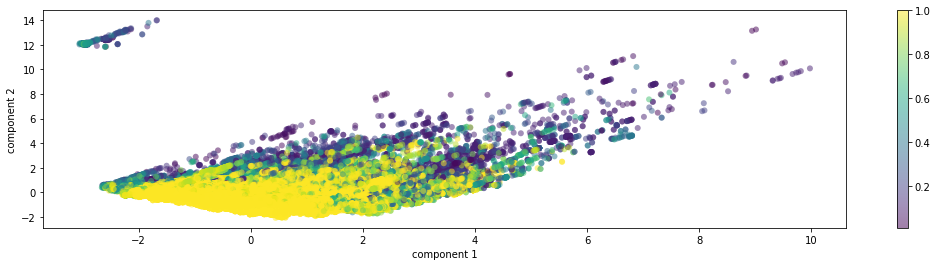

In [83]:
fig = plt.figure(figsize=(18, 4))
ax = fig.add_subplot()

plt.scatter(X_pca[:, 0], X_pca[:, 1], edgecolor='none', alpha=0.5, c=df["risco_fogo"].values)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.show()

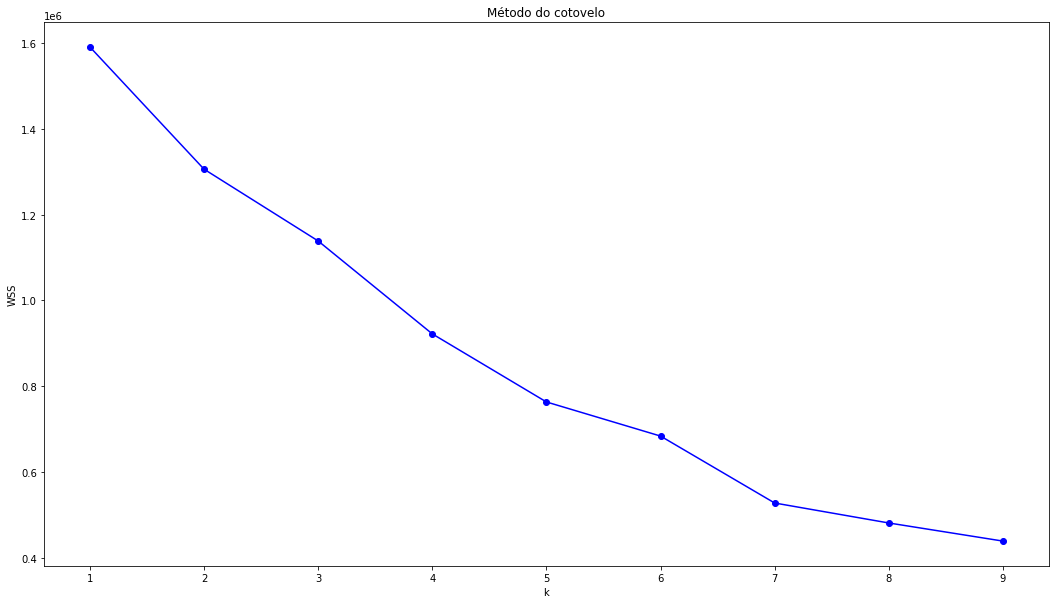

In [84]:
WSS = []  #Inicia uma lista vazia, para acumularmos valores.

for k in range(1,10): #Vamos fazer para 1 a 9 clusters.
    kmeans = KMeans(  #Inicializa o K-Means, como já explicado antes
        n_clusters=k, 
        init='random',
        n_init=10, 
        max_iter=300, 
        tol=1e-04, 
        random_state=0
    )
    y_kmeans = kmeans.fit_predict(X_pca) #Fita o K-Means
    WSS.append(kmeans.inertia_)          #Obtem a WSS e acumula na lista inicializada 
    
plt.figure(figsize=(18,10))              #Define o tamanho da figura
plt.plot(range(1,10), WSS, '-bo')        #Define o plot
plt.xlabel('k')                          #Nome da coordenada x
plt.ylabel('WSS')                        #Nome da coordenada y
plt.title('Método do cotovelo')          #Título do gráfico
plt.show()                               #Mostra o gráfico

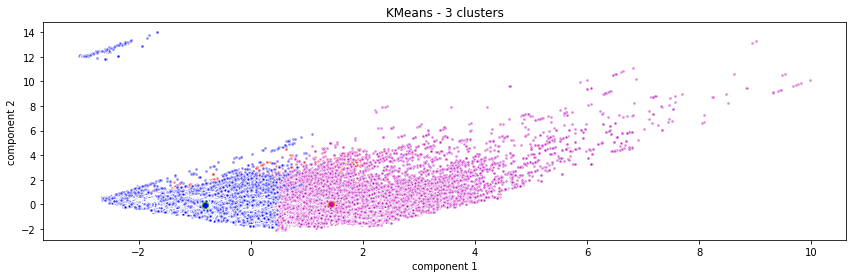

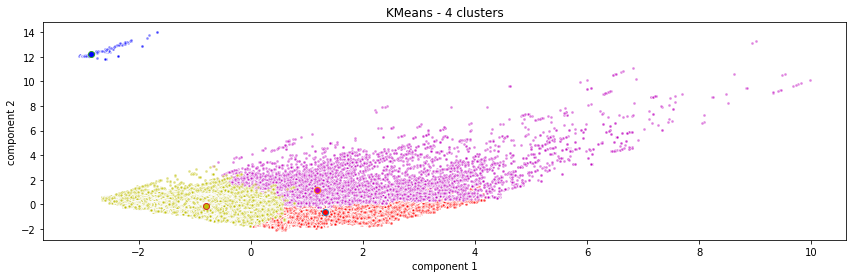

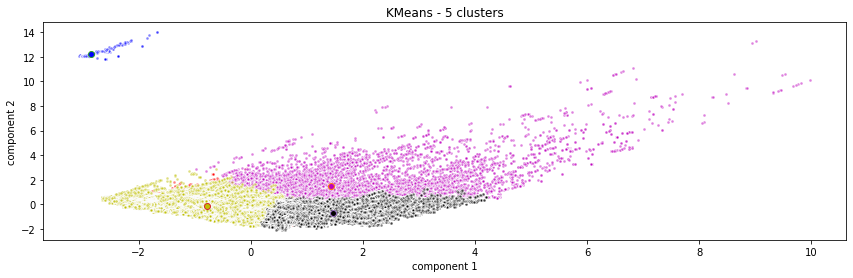

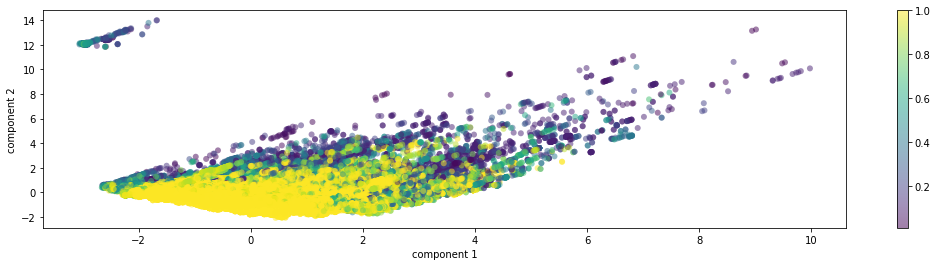

In [85]:
for numberofclusters in range(3,6):

    n_clusters=numberofclusters

    kmeans = KMeans(
        n_clusters=n_clusters, 
        init='random',
        n_init=10, 
        max_iter=300, 
        tol=1e-04, 
        random_state=0
    )

    y_kmeans = kmeans.fit_predict(X_pca)

    centroids = kmeans.cluster_centers_
    labels = pairwise_distances_argmin(X_pca, centroids)
    colors = ["r", "m", "b", "y", "k"]

    fig = plt.figure(figsize=(14.4, 4))
    ax = fig.add_subplot()

    for k, col in zip(range(n_clusters), colors):
        my_members = labels == k
        cluster_center = centroids[k]
        ax.plot(
            X_pca[my_members, 0],
            X_pca[my_members, 1],
            "w", 
            markerfacecolor=col,
            marker=".",
            alpha = 0.5,
            linewidth=0)
        ax.plot(
            cluster_center[0],
            cluster_center[1],
            "o",
            markerfacecolor=col,
            markersize=6,
            alpha = 1.0,
            linewidth=0
        )
    title = 'KMeans - ' + str(numberofclusters) + " clusters"
    ax.set_title(title)
    plt.xlabel('component 1')
    plt.ylabel('component 2')

    plt.show()


fig = plt.figure(figsize=(18, 4))
ax = fig.add_subplot()

plt.scatter(X_pca[:, 0], X_pca[:, 1], edgecolor='none', alpha=0.5, c=df["risco_fogo"].values)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.show()

### Plot 3D

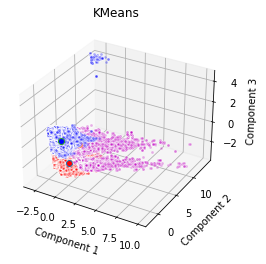

In [86]:
#%matplotlib notebook
#from mpl_toolkits import mplot3d

n_clusters=3

kmeans = KMeans(
    n_clusters=n_clusters, 
    init='random',
    n_init=10, 
    max_iter=300, 
    tol=1e-04, 
    random_state=0
)

y_kmeans = kmeans.fit_predict(X_pca)

centroids = kmeans.cluster_centers_
labels = pairwise_distances_argmin(X_pca, centroids)
colors = ["r", "m", "b", "y", "k"]

fig = plt.figure() #figsize=(22, 10))
ax = fig.add_subplot(projection='3d')

for k, col in zip(range(n_clusters), colors):
    my_members = labels == k
    cluster_center = centroids[k]
    ax.plot(
        X_pca[my_members, 0], 
        X_pca[my_members, 1],
        X_pca[my_members, 2],
        "w", 
        markerfacecolor=col, 
        marker=".",
        linewidth=0,
        alpha=0.3
    )
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        cluster_center[2],
        "o",
        markerfacecolor=col,
        #markeredgecolor="k",
        markersize=6,
    )

ax.set_title("KMeans")
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.show()
